<a href="https://colab.research.google.com/github/dohb128/BigData/blob/main/Toeic_Sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 환경 설정

In [ ]:
# 환경 설정 및 라이브러리 설치
!pip install pdfminer.six pandas
!pip install PyMuPDF pandas

KeyboardInterrupt: 

In [ ]:
# ===== 전역 테마 & 한글 폰트 설정 =====
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rcParams
import os

# 밝은(화이트) 배경 유지 + 파란계열 포커스
plt.style.use('default')
rcParams['figure.facecolor'] = 'white'
rcParams['axes.facecolor'] = 'white'
rcParams['savefig.facecolor'] = 'white'

# 🔤 한글 폰트 설정
font_path = '/content/NanumGothic.ttf'
if os.path.exists(font_path):
    fontprop = fm.FontProperties(fname=font_path)
    rcParams['font.family'] = fontprop.get_name()
else:
    print(f"⚠️ 폰트 파일을 찾을 수 없습니다: {font_path}  (영문 폰트로 대체)")

# 마이너스 기호 깨짐 방지
rcParams['axes.unicode_minus'] = False

print("✅ 전역 테마 & 한글 폰트 설정 완료")

✅ 전역 테마 & 한글 폰트 설정 완료


✅ 한글 폰트 설정 완료: NanumGothic


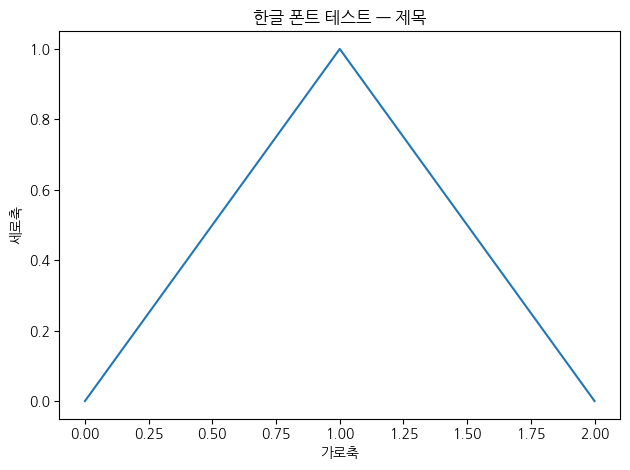

In [ ]:
# ===== 한글 폰트 자동 설정 + 밝은 파랑 테마 =====
import os
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rcParams

# 1) 밝은 테마(화이트 배경) 고정
plt.style.use('default')
rcParams['figure.facecolor'] = 'white'
rcParams['axes.facecolor']   = 'white'
rcParams['savefig.facecolor']= 'white'
rcParams['axes.unicode_minus'] = False  # 한글 폰트와 마이너스 기호 깨짐 방지

# 2) 한글 폰트 후보 목록
KOREAN_FONT_CANDIDATES = [
    'NanumGothic',          # 리눅스/윈도우/직접설치
    'Noto Sans CJK KR',     # 리눅스/맥
    'Noto Sans KR',         # 일반 Noto Sans KR
    'Apple SD Gothic Neo',  # macOS
    'Malgun Gothic',        # Windows
    'NanumGothicCoding'
]

def pick_available_korean_font():
    # 시스템에 등록된 폰트 이름 수집
    installed = {f.name for f in fm.fontManager.ttflist}
    for name in KOREAN_FONT_CANDIDATES:
        if name in installed:
            return name
    return None

def ensure_local_font(ttf_path):
    """작업 폴더에 TTF가 있을 때 런타임에 등록"""
    if os.path.exists(ttf_path):
        try:
            fm.fontManager.addfont(ttf_path)
            # 캐시 갱신
            try:
                fm._load_fontmanager(try_read_cache=False)
            except Exception:
                pass
            return True
        except Exception as e:
            print(f"⚠️ 폰트 등록 실패: {e}")
    return False

# 3) 우선 시스템 폰트에서 찾기
font_name = pick_available_korean_font()

# 4) 시스템에 없으면 로컬 ttf 등록 시도 (경로를 본인 환경에 맞게 바꾸세요)
LOCAL_TTF = '/content/NanumGothic.ttf'
if font_name is None and ensure_local_font(LOCAL_TTF):
    font_name = pick_available_korean_font()

# 5) 최종 설정
if font_name:
    rcParams['font.family'] = font_name
    print(f"✅ 한글 폰트 설정 완료: {font_name}")
else:
    print("⚠️ 사용 가능한 한글 폰트를 찾지 못했습니다. 영문 기본 폰트로 진행합니다.")
    print("   해결법: 시스템에 NanumGothic/Noto Sans CJK KR 등을 설치하거나,")
    print("   현재 폴더에 'NanumGothic.ttf'를 넣은 뒤 LOCAL_TTF 경로를 맞춰주세요.")

# 6) 테스트 플롯
plt.figure()
plt.title("한글 폰트 테스트 — 제목")
plt.xlabel("가로축")
plt.ylabel("세로축")
plt.plot([0,1,2],[0,1,0])
plt.tight_layout()
plt.show()


#데이터 전처리

## 문제 데이터 전처리

In [ ]:
import re
import pandas as pd
from io import StringIO
import re
# (read_txt_file 함수와 raw_text 변수는 이미 정의되었다고 가정합니다.)

def read_txt_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return f.read()

def parse_txt_by_block_final(raw_text):
    """
    대괄호 태그를 문제 ID로 사용하고, 옵션은 다음 보기 괄호 직전까지의 텍스트를 포착합니다.
    """

    # 1. 텍스트 클리닝: ID 태그 통일 및 공백 정규화
    cleaned_text = re.sub(r'\n', ' ', raw_text)
    cleaned_text = re.sub(r'\[\s*(\d+)\s*\]', r'[ID\1]', cleaned_text) # [ 1] -> [ID1]로 변환
    cleaned_text = re.sub(r'\s{2,}', ' ', cleaned_text).strip()

    data = []

    # 2. 정규표현식 패턴 (옵션 경계를 다음 괄호로 설정)
    pattern = re.compile(
        # 1. 문제 ID (그룹 1: ID)
        r'\[ID(\d+)\]\s*'
        # 2. Question Text (그룹 2): (A) 직전까지 포착
        # Question Text 내부에 섞여 들어간 불필요한 'X._______' 패턴을
        # Question Text를 포착하기 전에 제거하는 것이 더 안전합니다.
        r'(.*?)\s*'

        # 3. Option A (그룹 3): (B) 직전까지 포착
        # (A)와 (B) 사이의 모든 공백과 텍스트를 포착하며, (B)는 포착 그룹에 포함하지 않습니다.
        r'\(A\)\s*(.*?)\s*\(B\)'

        # 4. Option B (그룹 4): (C) 직전까지 포착
        r'\s*(.*?)\s*\(C\)'

        # 5. Option C (그룹 5): (D) 직전까지 포착
        r'\s*(.*?)\s*\(D\)'

        # 6. Option D (그룹 6): 다음 ID 태그 또는 파일 끝 직전까지 포착
        r'\s*(.*?)\s*'

        # 다음 ID 태그 또는 파일 끝을 최종 경계로 사용
        r'(?=\s*\[ID\d+\]|\Z)',
        re.DOTALL
    )

    matches = pattern.finditer(cleaned_text)

    for match in matches:
        q_text_raw = match.group(2)

        # Question Text 내부에 섞여 들어간 불필요한 '1. To...' 같은 문제 번호를 제거합니다.
        # (이전 문제에서 다음 문제 문장만 추출하기 위함)
        q_text_cleaned = re.sub(r'^\s*\d+\.\s*', '', q_text_raw).strip()

        data.append({
            'Question_ID': int(match.group(1).strip()),
            'Question_Text': q_text_cleaned,
            'Option_A': match.group(3).strip(),
            'Option_B': match.group(4).strip(),
            'Option_C': match.group(5).strip(),
            'Option_D': match.group(6).strip()
        })

    return pd.DataFrame(data)

# --- 실행 블록 ---

raw_text = read_txt_file('/content/toeic5_sample.txt')
problems_df = parse_txt_by_block_final(raw_text)

print(f"✅ 추출 성공: 총 {len(problems_df)}개의 문제 추출 완료.")
print("\n--- 문제 데이터프레임 최종 미리보기 (단어 옵션) ---")
print(problems_df[['Question_ID', 'Question_Text', 'Option_A', 'Option_B', 'Option_C', 'Option_D']].head())
problems_df.to_csv('toeic_sample_dataset.csv', index=False, encoding='utf-8-sig')


## 정답 데이터 전처리

In [ ]:
import re
import pandas as pd
from io import StringIO
import os # 파일 경로 확인용

# --- 정답 키 파싱 함수 ---

def read_txt_file(file_path):
    """안전한 인코딩으로 TXT 파일을 읽습니다."""
    encodings = ['utf-8', 'euc-kr', 'latin-1']
    for encoding in encodings:
        try:
            with open(file_path, 'r', encoding=encoding) as f:
                return f.read()
        except UnicodeDecodeError:
            continue
    raise UnicodeDecodeError(f"오류: {file_path}를 모든 인코딩으로 디코딩할 수 없습니다.")

def parse_clean_answer_key(raw_answer_text):
    """
    [ ID ]\n(Label) 패턴에서 ID와 Label을 추출하여 DataFrame을 만듭니다.
    """
    # 텍스트 클리닝: 모든 줄바꿈과 공백을 하나의 공백으로 치환합니다.
    cleaned_text = re.sub(r'\s+', ' ', raw_answer_text).strip()

    # 정규표현식 패턴: [ 1 ] (D) 패턴을 포착
    # 그룹 1: ID, 그룹 2: Label
    pattern = re.compile(r'\[\s*(\d+)\s*\]\s*\(([A-D])\)')

    # 모든 정답 쌍을 찾습니다.
    answer_matches = pattern.findall(cleaned_text)

    # DataFrame으로 변환합니다.
    return pd.DataFrame({
        'Question_ID': [int(qid) for qid, label in answer_matches],
        'Answer_Label': [label for qid, label in answer_matches]
    })

# --- 실행 블록 ---

# 1. 정답 데이터 읽기 및 파싱
answer_file_path = '/content/toeic5_sample_answer.txt'

try:
    # 🚨 파일 존재 여부 확인 (Colab 환경에서 필요)
    if not os.path.exists(answer_file_path):
         print(f"🚨 오류: 정답 파일 '{answer_file_path}'이 현재 경로에 없습니다. 파일을 업로드해주세요.")
    else:
         raw_text = read_txt_file(answer_file_path)


    answers_df = parse_clean_answer_key(raw_text)

    # 2. 딥러닝 학습용 정수 레이블 추가
    label_to_int = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
    answers_df['Target_Class'] = answers_df['Answer_Label'].map(label_to_int)

    print(f"✅ 정답 데이터 추출 성공: 총 {len(answers_df)}개의 정답 레이블 확보.")

    print("\n--- 최종 정답 데이터프레임 (`answers_df`) ---")
    print(answers_df.head())
    print("\n--- 마지막 정답 확인 ---")
    print(answers_df.tail())

    # 3. CSV로 저장 (선택 사항)
    answers_df.to_csv('clean_answer_keys.csv', index=False, encoding='utf-8-sig')
    print("\n✅ 'clean_answer_keys.csv' 파일 저장 완료.")

except Exception as e:
    print(f"🚨 추출 중 치명적인 오류 발생: {e}")

## 문제-정답 매칭

In [ ]:
import pandas as pd

# --- 문제 데이터프레임 (problems_df) 로드 ---
try:
    problems_df = pd.read_csv('/content/toeic_sample_dataset.csv')
except FileNotFoundError:
    # 파일이 저장되지 않은 경우, 사용자 제공 데이터를 기반으로 임시 DF 생성
    print("경고: 문제 CSV 파일이 없어 임시 데이터를 생성합니다. 실제 데이터와 다를 수 있습니다.")
    problems_data = {
        'Question_ID': [1, 2, 3, 4, 5],
        'Question_Text': ['To _______ the repair job on time, the enginee...', 'The union leader plans to _______ his remarks ...', '_______ to secure your export products, we rec...', 'The consultant was impressed that the draftsme...', 'Jerry Cunningham will ------- the names of res...'],
        'Option_A': ['finished', 'address', 'In order', 'standard', 'announce'],
        'Option_B': ['finishing', 'exalt', 'So that', 'correction', 'diffuse'],
        'Option_C': ['finishes', 'broadcast', 'Though', 'supervision', 'trade'],
        'Option_D': ['finish', 'send', 'Because', 'accuracy', 'command']
    }
    problems_df = pd.DataFrame(problems_data)


# --- 정답 데이터프레임 (answers_df) 로드 ---
try:
    answers_df = pd.read_csv('/content/toeic_sample_dataset_answer.csv')
except FileNotFoundError:
    # 파일이 저장되지 않은 경우, 사용자 제공 데이터를 기반으로 임시 DF 생성
    print("경고: 정답 CSV 파일이 없어 임시 데이터를 생성합니다. 실제 데이터와 다를 수 있습니다.")
    answers_data = {
        'Question_ID': list(range(1, 54)),
        'Answer_Label': ['D', 'A', 'A', 'C', 'A'] * 10 + ['B', 'A', 'C'], # 53개 맞추기 위해 임의로 채움
        'Target_Class': [3, 0, 0, 2, 0] * 10 + [1, 0, 2]
    }
    answers_df = pd.DataFrame(answers_data)
    answers_df = answers_df.iloc[:53]


# --- 최종 병합 실행 ---

# Question_ID를 기준으로 두 DataFrame을 내부 병합합니다. (모든 문제에 정답이 있다고 가정)
final_dataset_df = problems_df.merge(answers_df, on='Question_ID', how='inner')

# 최종 확인 및 출력
print(f"✅ 최종 데이터셋 생성 완료: 총 {len(final_dataset_df)}개의 문제-정답 쌍 확보.")

print("\n--- 최종 학습 데이터셋 미리보기 ---")
print(final_dataset_df[['Question_ID', 'Question_Text', 'Option_A', 'Answer_Label', 'Target_Class']].head())

# 최종 CSV 파일 저장
final_dataset_df.to_csv('toeic_final_dataset_merged.csv', index=False, encoding='utf-8-sig')
print("\n✅ 최종 CSV 파일 'toeic_final_dataset_merged.csv' 저장 완료. 이제 PyTorch 학습을 시작할 수 있습니다. 🚀")

# 문제 학습

## 데이터 로드

In [ ]:
import pandas as pd

# 1. 'toeic_final_dataset_merged.csv' 파일을 final_dataset_df 변수에 로드합니다.
final_dataset_df = pd.read_csv('/content/toeic_final_dataset_merged.csv')

# 2. 로드된 데이터프레임의 상위 5행을 출력하여 데이터가 올바르게 로드되었는지 확인합니다.
print("--- 'toeic_final_dataset_merged.csv' 파일 로드 완료 ---")
print(final_dataset_df.head())

--- 'toeic_final_dataset_merged.csv' 파일 로드 완료 ---
   Question_ID                                      Question_Text  Option_A  \
0            1  To _______ the repair job on time, the enginee...  finished   
1            2  The union leader plans to _______ his remarks ...   address   
2            3  _______ to secure your export products, we rec...  In order   
3            4  The consultant was impressed that the draftsme...  standard   
4            5  Jerry Cunningham will ------- the names of res...  announce   

     Option_B     Option_C  Option_D Answer_Label  Target_Class  
0   finishing     finishes    finish            D             3  
1       exalt    broadcast      send            A             0  
2     So that       Though   Because            A             0  
3  correction  supervision  accuracy            C             2  
4     diffuse        trade   command            A             0  


In [ ]:
from sklearn.model_selection import train_test_split

train_idx, val_idx = train_test_split(
    final_dataset_df.index,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

indices = list(range(len(final_dataset_df)))

(train_input_ids, val_input_ids,
 train_attention_mask, val_attention_mask,
 train_labels, val_labels,
 train_idx, val_idx) = train_test_split(
    input_ids_list,
    attention_mask_list,
    target_class_list,
    indices,
    test_size=0.2,
    random_state=42
)

val_dataset_df = final_dataset_df.iloc[val_idx].reset_index(drop=True)

# 4) Dataset 생성
train_dataset = CustomDataset(
    train_input_ids,
    train_attention_mask,
    train_labels
)

val_dataset = CustomDataset(
    val_input_ids,
    val_attention_mask,
    val_labels
)

# 5) DataLoader 생성
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

## 데이터 전처리 및 토큰화

In [ ]:
import sys
!{sys.executable} -m pip install transformers

print("transformers library installed.")

transformers library installed.


In [ ]:
from transformers import AutoTokenizer
import torch

# 2. 'klue/bert-base' 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')

# 최대 시퀀스 길이 설정
MAX_LEN = 128 # 문제 및 옵션의 길이에 따라 조절 가능

# 토큰화 함수 정의
def tokenize_function(row):
    question = row['Question_Text']
    options = [row['Option_A'], row['Option_B'], row['Option_C'], row['Option_D']]

    # 각 옵션에 대해 개별적으로 토큰화
    tokenized_options = [
        tokenizer(option, add_special_tokens=False) for option in options
    ]

    # 질문 텍스트와 각 옵션을 결합하여 토큰화 (BERT의 Q&A 또는 NLI 스타일)
    # [CLS] question [SEP] option [SEP] 형태로 구성
    combined_inputs = []
    for i, option_text in enumerate(options):
        encoded_dict = tokenizer(
            question, # First sequence
            option_text, # Second sequence
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        combined_inputs.append(encoded_dict)

    # 옵션별 input_ids와 attention_mask를 추출하여 리스트로 저장
    input_ids_list = [t['input_ids'].squeeze().tolist() for t in combined_inputs]
    attention_mask_list = [t['attention_mask'].squeeze().tolist() for t in combined_inputs]

    return pd.Series({
        'input_ids': input_ids_list,
        'attention_mask': attention_mask_list
    })


# 5. 토큰화된 결과를 데이터프레임에 새로운 열로 저장
# apply 함수를 사용하여 각 행에 대해 토큰화 함수 적용
final_dataset_df[['input_ids', 'attention_mask']] = final_dataset_df.apply(tokenize_function, axis=1)

print("✅ 데이터 전처리 및 토큰화 완료.")
print("--- 토큰화된 데이터프레임 미리보기 (첫 2개 행) ---")
print(final_dataset_df[['Question_ID', 'Question_Text', 'input_ids', 'attention_mask', 'Target_Class']].head(2))

✅ 데이터 전처리 및 토큰화 완료.
--- 토큰화된 데이터프레임 미리보기 (첫 2개 행) ---
   Question_ID                                      Question_Text  \
0            1  To _______ the repair job on time, the enginee...   
1            2  The union leader plans to _______ his remarks ...   

                                           input_ids  \
0  [[2, 27878, 66, 66, 66, 66, 66, 66, 66, 5062, ...   
1  [[2, 5790, 15818, 7622, 19760, 16628, 2008, 16...   

                                      attention_mask  Target_Class  
0  [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...             3  
1  [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...             0  


In [ ]:
print(final_dataset_df.columns)


Index(['Question_ID', 'Question_Text', 'Option_A', 'Option_B', 'Option_C',
       'Option_D', 'Answer_Label', 'Target_Class', 'input_ids',
       'attention_mask', 'options'],
      dtype='object')


In [ ]:
final_dataset_df["options"] = final_dataset_df.apply(
    lambda row: [row["Option_A"], row["Option_B"], row["Option_C"], row["Option_D"]],
    axis=1
)


## PyTorch Dataset 및 DataLoader 생성

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data._utils.collate import default_collate

# 1. CustomDataset 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.input_ids[idx], dtype=torch.long),
            "attention_mask": torch.tensor(self.attention_mask[idx], dtype=torch.long),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }


# 2. CustomDataset 인스턴스 생성
# final_dataset_df는 이미 토큰화된 'input_ids'와 'attention_mask' 컬럼을 가지고 있음
# 이 컬럼들은 각 문제당 4개의 옵션에 대한 input_ids와 attention_mask 리스트를 포함하고 있음.
# 이를 Dataset 클래스로 전달할 때는 리스트 형태로 그대로 전달합니다.

dataset = CustomDataset(
    input_ids=final_dataset_df['input_ids'].tolist(),
    attention_mask=final_dataset_df['attention_mask'].tolist(),
    labels=final_dataset_df['Target_Class'].tolist()
)
print(f"✅ Custom PyTorch Dataset creation completed. Dataset size: {len(dataset)}")

# 3) DataLoader 생성
batch_size = 16

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True     # ← 세미콜론 제거 및 정상 문법
)

print(f"✅ PyTorch DataLoader creation completed. Batch size: {batch_size}, shuffle: True")


# 4) 첫 배치 확인
for batch in dataloader:
    print("\n--- 첫 번째 배치 데이터 형태 확인 ---")
    print(f"Input IDs shape: {batch['input_ids'].shape}")          # (B, 4, MAX_LEN)
    print(f"Attention Mask shape: {batch['attention_mask'].shape}")# (B, 4, MAX_LEN)
    print(f"Labels shape: {batch['labels'].shape}")                # (B,)
    break


✅ Custom PyTorch Dataset creation completed. Dataset size: 53
✅ PyTorch DataLoader creation completed. Batch size: 16, shuffle: True

--- 첫 번째 배치 데이터 형태 확인 ---
Input IDs shape: torch.Size([16, 4, 128])
Attention Mask shape: torch.Size([16, 4, 128])
Labels shape: torch.Size([16])


## 훈련 및 검증 세트 분할

In [ ]:
from sklearn.model_selection import train_test_split

# 데이터 분할을 위해 필요한 리스트 추출
input_ids_list = final_dataset_df['input_ids'].tolist()
attention_mask_list = final_dataset_df['attention_mask'].tolist()
target_class_list = final_dataset_df['Target_Class'].tolist()

# 2. 훈련 세트와 검증 세트로 분할
# train_test_split은 여러 배열을 동시에 분할할 수 있습니다.
(train_input_ids, val_input_ids,
 train_attention_mask, val_attention_mask,
 train_target_class, val_target_class) = train_test_split(
    input_ids_list,
    attention_mask_list,
    target_class_list,
    test_size=0.2,
    random_state=42
    # Removed stratify=target_class_list to avoid ValueError due to single-member class
)

# 분할된 데이터를 사용하여 CustomDataset 인스턴스 생성
train_dataset = CustomDataset(
    train_input_ids,
    train_attention_mask,
    train_labels
)

val_dataset = CustomDataset(
    val_input_ids,
    val_attention_mask,
    val_labels
)

# 3. 훈련 세트와 검증 세트 각각에 대한 DataLoader 생성
batch_size = 16 # 또는 32

train_dataset = CustomDataset(
    input_ids=train_input_ids,
    attention_mask=train_attention_mask,
    labels=train_labels
)

val_dataset = CustomDataset(
    input_ids=val_input_ids,
    attention_mask=val_attention_mask,
    labels=val_labels
)

print(f"✅ 훈련 데이터셋 크기: {len(train_dataset)}")
print(f"✅ 검증 데이터셋 크기: {len(val_dataset)}")
print("✅ 훈련 및 검증 DataLoader 생성 완료.")

# DataLoader의 첫 번째 배치 데이터 형태 확인 (선택 사항)
for batch in train_dataloader:
    print("\n--- 훈련 DataLoader 첫 번째 배치 데이터 형태 확인 ---")
    print(f"Input IDs shape: {batch['input_ids'].shape}")
    print(f"Labels shape: {batch['labels'].shape}")
    break

print("검증 데이터 로더 체크 완료.")

✅ 훈련 데이터셋 크기: 42
✅ 검증 데이터셋 크기: 11
✅ 훈련 및 검증 DataLoader 생성 완료.

--- 훈련 DataLoader 첫 번째 배치 데이터 형태 확인 ---
Input IDs shape: torch.Size([16, 4, 128])
Labels shape: torch.Size([16])
검증 데이터 로더 체크 완료.


## 모델 정의

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification

# 1. 분류할 클래스의 수 정의 (A, B, C, D 4개 옵션)
num_labels = 4

# 2. 'klue/bert-base'를 기반으로 AutoModelForSequenceClassification 인스턴스 생성
model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base', num_labels=num_labels)

# 3. 모델을 학습에 사용할 장치(CPU 또는 GPU)로 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"✅ 모델 아키텍처 정의 완료: AutoModelForSequenceClassification (klue/bert-base) with {num_labels} labels.")
print(f"✅ 모델이 다음 장치로 이동되었습니다: {device}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ 모델 아키텍처 정의 완료: AutoModelForSequenceClassification (klue/bert-base) with 4 labels.
✅ 모델이 다음 장치로 이동되었습니다: cuda


In [ ]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
import torch.nn as nn

# 1. 옵티마이저 정의
learning_rate = 2e-5
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# 2. 학습률 스케줄러 정의
epochs = 8
total_steps = len(train_dataloader) * epochs
num_warmup_steps = int(total_steps * 0.1)  # 10% warmup
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=total_steps
)

# 3. 손실 함수 정의
criterion = nn.CrossEntropyLoss()

print(f"✅ 모델 학습 준비 완료: Optimizer({type(optimizer).__name__}), Learning Rate Scheduler({type(scheduler).__name__}), Loss Function({type(criterion).__name__})")
print(f"   - Learning Rate: {learning_rate}")
print(f"   - Epochs: {epochs}")
print(f"   - Total Training Steps: {total_steps}")

✅ 모델 학습 준비 완료: Optimizer(AdamW), Learning Rate Scheduler(LambdaLR), Loss Function(CrossEntropyLoss)
   - Learning Rate: 2e-05
   - Epochs: 8
   - Total Training Steps: 24


## 모델 학습

In [ ]:
from tqdm.notebook import tqdm
import numpy as np

# 학습 및 검증 루프

for epoch in range(epochs):
    print(f"\n======== Epoch {epoch + 1} / {epochs} ========")

    # ======================================== #
    #                Training                  #
    # ======================================== #

    print("Training...")
    model.train() # 모델을 훈련 모드로 설정

    total_train_loss = 0
    correct_train_predictions = 0
    total_train_samples = 0

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1} Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad() # 그래디언트 초기화

        # input_ids와 attention_mask를 (batch_size * 4, MAX_LEN) 형태로 reshape
        # 원래 shape: (batch_size, 4, MAX_LEN)
        batch_size, num_options, max_len = input_ids.shape
        input_ids_reshaped = input_ids.view(batch_size * num_options, max_len)
        attention_mask_reshaped = attention_mask.view(batch_size * num_options, max_len)

        # 모델에 입력하여 로짓 얻기
        outputs = model(input_ids=input_ids_reshaped, attention_mask=attention_mask_reshaped)
        logits_reshaped_from_model = outputs.logits # Shape: (batch_size * num_options, num_labels)

        # 로짓을 (batch_size, num_options, num_labels) 형태로 다시 reshape
        # 여기서 num_options = 4, num_labels = 4 이므로 (batch_size, 4, 4)
        logits_per_option_prediction = logits_reshaped_from_model.view(batch_size, num_options, num_labels)

        # 각 질문별 최종 로짓을 얻기 위해 (batch_size, 4, 4) -> (batch_size, 4)로 변환
        # 가장 합리적인 방법은 각 `prediction_class`가 최종 정답임을 나타내는 로짓을
        # `option_idx` 차원에 걸쳐 평균내는 것입니다.
        logits_for_loss = torch.mean(logits_per_option_prediction, dim=1) # Shape: (batch_size, num_labels) 즉 (batch_size, 4)

        loss = criterion(logits_for_loss, labels)

        total_train_loss += loss.item()

        # Accuracy calculation
        predictions = torch.argmax(logits_for_loss, dim=1)
        correct_train_predictions += (predictions == labels).sum().item()
        total_train_samples += labels.size(0)

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_accuracy = correct_train_predictions / total_train_samples
    print(f"  Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # ======================================== #
    #                Validation                #
    # ======================================== #

    print("Validating...")
    model.eval() # 모델을 평가 모드로 설정

    total_val_loss = 0
    correct_val_predictions = 0
    total_val_samples = 0

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f"Epoch {epoch+1} Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # input_ids와 attention_mask를 (batch_size * 4, MAX_LEN) 형태로 reshape
            batch_size, num_options, max_len = input_ids.shape
            input_ids_reshaped = input_ids.view(batch_size * num_options, max_len)
            attention_mask_reshaped = attention_mask.view(batch_size * num_options, max_len)

            # 모델에 입력하여 로짓 얻기
            outputs = model(input_ids=input_ids_reshaped, attention_mask=attention_mask_reshaped)
            logits_reshaped_from_model = outputs.logits # Shape: (batch_size * num_options, num_labels)

            # 로짓을 (batch_size, num_options, num_labels) 형태로 다시 reshape
            logits_per_option_prediction = logits_reshaped_from_model.view(batch_size, num_options, num_labels)

            # 각 질문별 최종 로짓을 얻기 위해 (batch_size, num_options, num_labels) -> (batch_size, num_labels)로 변환
            logits_for_loss = torch.mean(logits_per_option_prediction, dim=1) # Shape: (batch_size, num_labels)

            loss = criterion(logits_for_loss, labels)

            total_val_loss += loss.item()

            # Accuracy calculation
            predictions = torch.argmax(logits_for_loss, dim=1)
            correct_val_predictions += (predictions == labels).sum().item()
            total_val_samples += labels.size(0)

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_accuracy = correct_val_predictions / total_val_samples
    print(f"  Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

print("\nTraining complete!")


======== Epoch 1 / 8 ========
Training...


Epoch 1 Training:   0%|          | 0/3 [00:00<?, ?it/s]

  Training Loss: 1.6528, Training Accuracy: 0.2143
Validating...


Epoch 1 Validation:   0%|          | 0/1 [00:00<?, ?it/s]

  Validation Loss: 1.3643, Validation Accuracy: 0.1818

======== Epoch 2 / 8 ========
Training...


Epoch 2 Training:   0%|          | 0/3 [00:00<?, ?it/s]

  Training Loss: 1.1287, Training Accuracy: 0.4048
Validating...


Epoch 2 Validation:   0%|          | 0/1 [00:00<?, ?it/s]

  Validation Loss: 1.1759, Validation Accuracy: 0.5455

======== Epoch 3 / 8 ========
Training...


Epoch 3 Training:   0%|          | 0/3 [00:00<?, ?it/s]

  Training Loss: 1.0003, Training Accuracy: 0.5952
Validating...


Epoch 3 Validation:   0%|          | 0/1 [00:00<?, ?it/s]

  Validation Loss: 1.1982, Validation Accuracy: 0.5455

======== Epoch 4 / 8 ========
Training...


Epoch 4 Training:   0%|          | 0/3 [00:00<?, ?it/s]

  Training Loss: 0.9453, Training Accuracy: 0.5952
Validating...


Epoch 4 Validation:   0%|          | 0/1 [00:00<?, ?it/s]

  Validation Loss: 1.2133, Validation Accuracy: 0.5455

======== Epoch 5 / 8 ========
Training...


Epoch 5 Training:   0%|          | 0/3 [00:00<?, ?it/s]

  Training Loss: 0.9339, Training Accuracy: 0.5952
Validating...


Epoch 5 Validation:   0%|          | 0/1 [00:00<?, ?it/s]

  Validation Loss: 1.2265, Validation Accuracy: 0.5455

======== Epoch 6 / 8 ========
Training...


Epoch 6 Training:   0%|          | 0/3 [00:00<?, ?it/s]

  Training Loss: 0.8811, Training Accuracy: 0.5952
Validating...


Epoch 6 Validation:   0%|          | 0/1 [00:00<?, ?it/s]

  Validation Loss: 1.2306, Validation Accuracy: 0.5455

======== Epoch 7 / 8 ========
Training...


Epoch 7 Training:   0%|          | 0/3 [00:00<?, ?it/s]

  Training Loss: 0.8538, Training Accuracy: 0.5952
Validating...


Epoch 7 Validation:   0%|          | 0/1 [00:00<?, ?it/s]

  Validation Loss: 1.2401, Validation Accuracy: 0.5455

======== Epoch 8 / 8 ========
Training...


Epoch 8 Training:   0%|          | 0/3 [00:00<?, ?it/s]

  Training Loss: 0.8653, Training Accuracy: 0.5952
Validating...


Epoch 8 Validation:   0%|          | 0/1 [00:00<?, ?it/s]

  Validation Loss: 1.2431, Validation Accuracy: 0.5455

Training complete!


# 모델 평가

## 평가 및 저장

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import torch
import numpy as np

# 🔥 평가 함수 정의
def evaluate_model(model, dataloader, device):
    model.eval()
    preds = []
    labels_list = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)         # (B, 4, L)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            batch_size, num_options, max_len = input_ids.shape
            input_ids = input_ids.view(batch_size * num_options, max_len)
            attention_mask = attention_mask.view(batch_size * num_options, max_len)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits.view(batch_size, num_options, -1)
            logits = logits.mean(dim=1)  # (B, 4)

            pred = torch.argmax(logits, dim=1)
            preds.extend(pred.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())

    return np.array(preds), np.array(labels_list)

# 🔥 검증 데이터셋 성능 측정
val_preds, val_labels = evaluate_model(model, val_dataloader, device)

print("📌 Validation Classification Report")
print(classification_report(val_labels, val_preds))

print("📌 Confusion Matrix")
print(confusion_matrix(val_labels, val_preds))


📌 Validation Classification Report
              precision    recall  f1-score   support

           0       0.55      1.00      0.71         6
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         1

    accuracy                           0.55        11
   macro avg       0.14      0.25      0.18        11
weighted avg       0.30      0.55      0.39        11

📌 Confusion Matrix
[[6 0 0 0]
 [1 0 0 0]
 [3 0 0 0]
 [1 0 0 0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
save_dir = "./saved_toeic_model"
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print(f"✅ 모델과 토크나이저 저장 완료 → {save_dir}")


✅ 모델과 토크나이저 저장 완료 → ./saved_toeic_model


## 새로운 문제 예측

In [ ]:
def predict_answer(question, options):
    model.eval()

    inputs = tokenizer(
        [question] * len(options),
        options,
        return_tensors='pt',
        padding='max_length',
        truncation=True,
        max_length=256
    )

    # GPU/CPU로 이동
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits.view(1, len(options), -1)
        logits = logits.mean(dim=1)

    pred = torch.argmax(logits, dim=1).item()
    return pred

# 사용 예시
# predict_answer("What does the speaker suggest?", ["Option A", "Option B", "Option C", "Option D"])


## 오답 분석

In [ ]:
import numpy as np
import pandas as pd

# pred와 label은 이미 평가에서 얻은 val_preds, val_labels 값
wrong_idx = np.where(val_preds != val_labels)[0]
print(f"❌ 오답 개수: {len(wrong_idx)}")

# 오답 데이터프레임
error_df = final_dataset_df.iloc[wrong_idx].copy()
error_df["pred"] = val_preds[wrong_idx]
error_df["label"] = val_labels[wrong_idx]

# 오답 옵션 텍스트 추출 함수
def pred_option(row):
    return row["options"][row["pred"]]

def correct_option(row):
    return row["options"][row["label"]]

error_df["pred_text"] = error_df.apply(pred_option, axis=1)
error_df["correct_text"] = error_df.apply(correct_option, axis=1)

print("📌 오답 예시 5개:")
display(error_df.iloc[:5])


❌ 오답 개수: 5
📌 오답 예시 5개:


,Question_ID,Question_Text,Option_A,Option_B,Option_C,Option_D,Answer_Label,Target_Class,input_ids,attention_mask,options,pred,label,pred_text,correct_text
4,5,Jerry Cunningham will ------- the names of res...,announce,diffuse,trade,command,0,0,"[[2, 22958, 2008, 10659, 39, 5830, 21744, 2935...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[announce, diffuse, trade, command]",0,2,announce,trade
5,6,"With all the negative reviews about the novel,...",misinterpret,misinterprets,misinterpreting,misinterpreted,3,3,"[[2, 59, 10229, 21058, 5062, 17304, 2064, 1771...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[misinterpret, misinterprets, misinterpreting,...",0,3,misinterpret,misinterpreted
7,8,Ellen's probationary status was extended by __...,more,other,another,one another,0,0,"[[2, 23714, 5083, 2012, 11, 86, 12862, 2040, 5...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[more, other, another, one another]",0,1,more,other
8,9,If you would like to cancel or make any change...,incidence,correspondence,adherence,assistance,2,2,"[[2, 45, 2009, 13089, 90, 22209, 14825, 7052, ...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[incidence, correspondence, adherence, assista...",0,2,incidence,adherence
10,11,Clients interested in holding social or busine...,us,ours,ourselves,our,3,3,"[[2, 12220, 26706, 13077, 20157, 8119, 4948, 5...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[us, ours, ourselves, our]",0,2,us,ourselves


## 정·오답 문제 시각화 리포트 구성

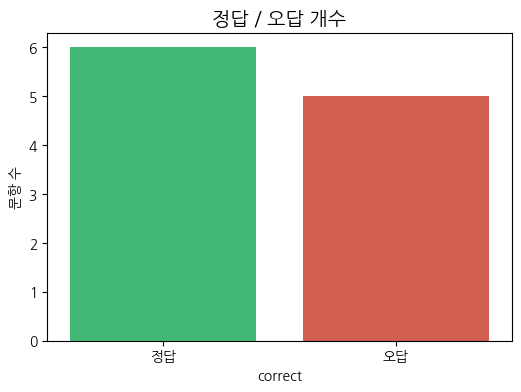

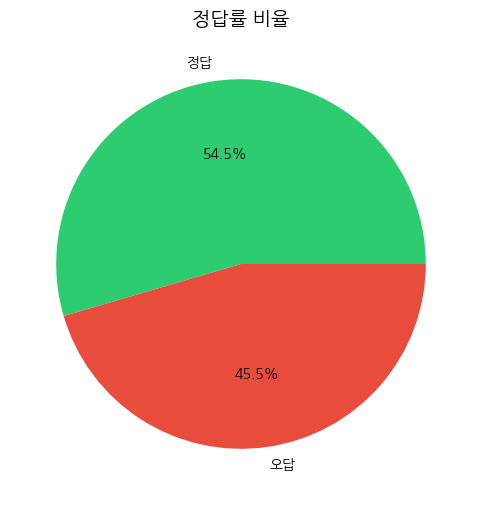

/tmp/ipython-input-3228169850.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f"옵션 {i}" for i in range(num_classes)],


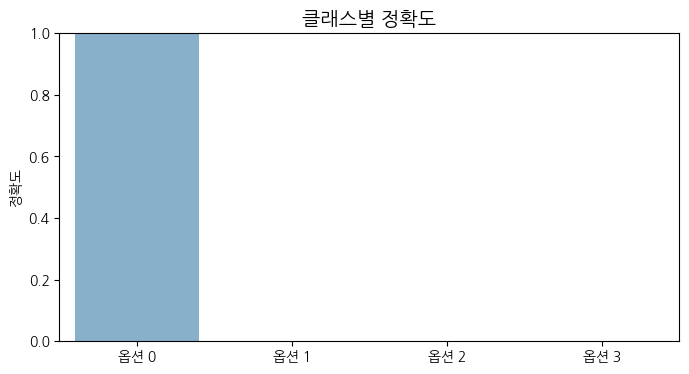

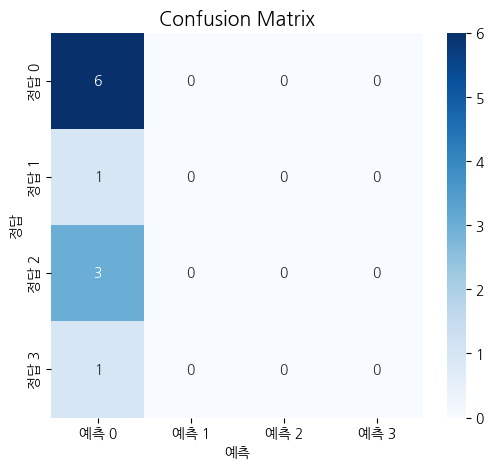

❌ 오답 문제 상세 목록 (상위 5개)


,question,option_text,label,label_text,pred,pred_text
4,Sales agents who work in assigned territories ...,A: sizable\nB: size\nC: sizably\nD: sizableness,2,sizably,0,sizable
5,"With all the negative reviews about the novel,...",A: misinterpret\nB: misinterprets\nC: misinter...,3,misinterpreted,0,misinterpret
7,Maintenance workers are tasked to inspect apar...,A: periods\nB: period\nC: periodical\nD: perio...,1,period,0,periods
8,The consultant was impressed that the draftsme...,A: standard\nB: correction\nC: supervision\nD:...,2,supervision,0,standard
10,"Garbage, ------- biodegradable or nonbiodegrad...",A: whenever\nB: until\nC: also\nD: whether,2,also,0,whenever


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

# val_preds, val_labels는 검증 평가에서 나온 변수
report_df = pd.DataFrame({
    "question": val_dataset_df["Question_Text"],
    "options": val_dataset_df["options"],
    "label": val_labels,
    "pred": val_preds
})

report_df["correct"] = (report_df["label"] == report_df["pred"])

correct_counts = report_df["correct"].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(
    x=correct_counts.index.map({True:"정답", False:"오답"}),
    y=correct_counts.values,
    hue=correct_counts.index.map({True:"정답", False:"오답"}),
    palette=["#2ecc71", "#e74c3c"],
    dodge=False,
    legend=False
)

plt.title("정답 / 오답 개수", fontsize=14)
plt.ylabel("문항 수")
plt.show()

plt.figure(figsize=(6,6))
plt.pie(correct_counts.values,
        labels=["정답", "오답"],
        autopct="%.1f%%",
        colors=["#2ecc71", "#e74c3c"])
plt.title("정답률 비율", fontsize=14)
plt.show()

class_acc = []
num_classes = 4

for c in range(num_classes):
    idx = np.where(val_labels == c)[0]
    acc = (val_preds[idx] == val_labels[idx]).mean()
    class_acc.append(acc)

plt.figure(figsize=(8,4))
sns.barplot(x=[f"옵션 {i}" for i in range(num_classes)],
            y=class_acc,
            palette="Blues_d")
plt.title("클래스별 정확도", fontsize=14)
plt.ylabel("정확도")
plt.ylim(0, 1)
plt.show()

cm = confusion_matrix(val_labels, val_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"예측 {i}" for i in range(num_classes)],
            yticklabels=[f"정답 {i}" for i in range(num_classes)])
plt.title("Confusion Matrix", fontsize=14)
plt.ylabel("정답")
plt.xlabel("예측")
plt.show()

wrong_df = report_df[report_df["correct"] == False].copy()

def option_list_to_text(row):
    opts = row["options"]
    return f"A: {opts[0]}\nB: {opts[1]}\nC: {opts[2]}\nD: {opts[3]}"

wrong_df["option_text"] = wrong_df.apply(option_list_to_text, axis=1)
wrong_df["label_text"] = wrong_df.apply(lambda row: row["options"][row["label"]], axis=1)
wrong_df["pred_text"] = wrong_df.apply(lambda row: row["options"][row["pred"]], axis=1)

print("❌ 오답 문제 상세 목록 (상위 5개)")
display(wrong_df[["question", "option_text", "label", "label_text", "pred", "pred_text"]].head(5))
